# Explore optimal round schedules

There are a variety of benefits to doing ballot-polling audits in distinct rounds.
E.g., when each round is sorted by ballot location, it is more efficient to retrieve the selected ballots.
If an audit is coordinated across multiple counties, it is helpful to have them each do their piece
of the auditing and then do a coordinated check for whether the audit is done.

But auditing in rounds means some efficiency in the overall audit is lost, because the audit doesn't have the opportunity to stop as soon as possible.

This notebook has code to calculate the average number of ballots audited when it is done in rounds, and explores the effects of different round schedules.

TODO:
* Write a function to optimize over batch schedules for given margin, number of ballots, speedup
* Optimize by overall cost (assuming costs for pulling a ballot, pulling a new batch, etc.
* allow more generality by deriving (or calculating, if possible) functions for the stopping size at each quantile.

## Preparation

Prepare `quantiles` dict-of-dicts based on BRAVO results.

Import quantile table from BRAVO paper: https://www.usenix.org/system/files/conference/evtwote12/evtwote12-final27.pdf

In [77]:
import math

In [1]:
bravo_table_1 = """True Share 25th 50th 75th 90th 99th Mean ASN
70% 12 22 38 60 131 30 30
65% 23 38 66 108 236 53 53
60% 49 84 149 244 538 119 119
58% 77 131 231 381 840 184 185
55% 193 332 587 974 2,157 469 469
54% 301 518 916 1,520 3,366 730 731
53% 531 914 1,619 2,700 5,980 1,294 1,295
52% 1,188 2,051 3637 6,053 13,455 2,900 2,902
51% 4,725 8,157 14,486 24,149 53,640 11,556 11,562
50.5% 18,839 32,547 57,838 96,411 214,491 46,126 46,150"""

In [2]:
quantile_list = [25, 50, 75, 90, 99]

In [3]:
columnnames = quantile_list + ["mean", "asn"]

In [4]:
columnnames

[25, 50, 75, 90, 99, 'mean', 'asn']

In [5]:
# Develop and print quantiles by margin
quantiles = {}

for row in bravo_table_1.split('\n')[1:]:
    row = row.replace(",", "").replace("%", "")
    cols = row.split()
    winner_share = float(cols[0]) / 100
    vals = [int(v) for v in cols[1:]]
    # print(winner_share, list(zip(columnnames, vals)))
    
    margin = round(winner_share - (1.0 - winner_share), 2)
    quantiles[margin] = dict(zip(columnnames, vals))
    print(margin, quantiles[margin])

0.4 {25: 12, 50: 22, 75: 38, 90: 60, 99: 131, 'mean': 30, 'asn': 30}
0.3 {25: 23, 50: 38, 75: 66, 90: 108, 99: 236, 'mean': 53, 'asn': 53}
0.2 {25: 49, 50: 84, 75: 149, 90: 244, 99: 538, 'mean': 119, 'asn': 119}
0.16 {25: 77, 50: 131, 75: 231, 90: 381, 99: 840, 'mean': 184, 'asn': 185}
0.1 {25: 193, 50: 332, 75: 587, 90: 974, 99: 2157, 'mean': 469, 'asn': 469}
0.08 {25: 301, 50: 518, 75: 916, 90: 1520, 99: 3366, 'mean': 730, 'asn': 731}
0.06 {25: 531, 50: 914, 75: 1619, 90: 2700, 99: 5980, 'mean': 1294, 'asn': 1295}
0.04 {25: 1188, 50: 2051, 75: 3637, 90: 6053, 99: 13455, 'mean': 2900, 'asn': 2902}
0.02 {25: 4725, 50: 8157, 75: 14486, 90: 24149, 99: 53640, 'mean': 11556, 'asn': 11562}
0.01 {25: 18839, 50: 32547, 75: 57838, 90: 96411, 99: 214491, 'mean': 46126, 'asn': 46150}


In [119]:
def mean_via_rounds(margin, round_quantiles, ballots=100000, batch_counting_speedup=10):
    """For a given list of round sizes, specified by a list of quantiles,
    return the average number of ballots audited, as both a raw number
    and as a multiple of the mean value for auditing with rounds of size 1.
    """

    last_q = 0
    total = 0.0
    for q in round_quantiles:
        total += (q - last_q) / 100 * quantiles[margin][q]
        last_q = q

    # Cost of full hand count in comparable units * probability that we escalate to a full hand count
    full_hand_count_contribution = ballots / batch_counting_speedup * (1.0 - round_quantiles[-1]/100.)
    total += full_hand_count_contribution

    return (math.ceil(total), round(total / quantiles[margin]['asn'], 3))

In [114]:
fmt = 'Multiplier: {excess:.3f}, ballots: {avg_ballots:.0f} for {margin:.1%} margin, round schedule: {roundqs}'
def show_multipliers(margin, round_schedules, ballots=100000, batch_counting_speedup=10):

    print("Multipliers for election with %.0f ballots, %.1f speedup per ballot for full hand count via %.2f margin" %
        (ballots, batch_counting_speedup, margin))
    avg_ballots, excess = quantiles[margin]["asn"], 1.0
    roundqs = "one ballot per round"
    print(fmt.format(**locals()))
    for roundqs in round_schedules:
        avg_ballots, excess = mean_via_rounds(margin, roundqs, ballots, batch_counting_speedup)
        print(fmt.format(**locals()))
        # print(f'Multiplier: {excess:.3f}, ballots: {avg_ballots:.0f} for {margin:.1%}, '
        #    f'round schedule {roundqs}')

In [80]:
def grid(margin):
    for quantile in [25, 50, 75, 90]:
        qs90 = [quantile, 90]
        qs99 = [quantile, 99]
        print("%s %s %s %s" % (qs90, mean_via_rounds(margin, qs90), qs99, mean_via_rounds(margin, qs99)))

In [120]:
grid(0.08)

[25, 90] (2064, 2.823) [25, 99] (2667, 3.647)
[50, 90] (1867, 2.554) [50, 99] (2009, 2.747)
[75, 90] (1915, 2.62) [75, 99] (1595, 2.182)
[90, 90] (2368, 3.239) [90, 99] (1771, 2.423)


In [88]:
grid(0.08)

[25, 90] (2064, 2.823) [25, 99] (2667, 3.647)
[50, 90] (1867, 2.554) [50, 99] (2009, 2.747)
[75, 90] (1915, 2.62) [75, 99] (1595, 2.182)
[90, 90] (2368, 3.239) [90, 99] (1771, 2.423)


In [89]:
grid(0.04)

[25, 90] (5232, 1.803) [25, 99] (10354, 3.568)
[50, 90] (4447, 1.532) [50, 99] (7719, 2.66)
[75, 90] (4636, 1.597) [75, 99] (6057, 2.087)
[90, 90] (6448, 2.222) [90, 99] (6759, 2.329)


In [90]:
grid(0.02)

[25, 90] (17879, 1.546) [25, 99] (40975, 3.544)
[50, 90] (14739, 1.275) [50, 99] (30463, 2.635)
[75, 90] (15487, 1.339) [75, 99] (23839, 2.062)
[90, 90] (22735, 1.966) [90, 99] (26662, 2.306)


In [91]:
grid(0.01)

[25, 90] (68377, 1.482) [25, 99] (163534, 3.544)
[50, 90] (55838, 1.21) [50, 99] (121475, 2.632)
[75, 90] (58841, 1.275) [75, 99] (94957, 2.058)
[90, 90] (87770, 1.902) [90, 99] (106175, 2.301)


## Show average audit sizes for several round schedules and two margins

In [122]:
# Define a number of round schedules to study.
# Each one, on a single line here, specifies a sequence of round sizes for a single audit.
# Define round sizes by the percentage (quantile) of audits for which the audit is expected to succeed.
# I.e. for the round schedule [50, 90, 99], with a margin of 10%, the round sizes (from the BRAVO table)
# would be determined to be [332, 974, 2157]
round_schedules = [
    [25, 50, 75, 90, 99],
    [50, 75, 90, 99],
    [50, 90, 99],
    [75, 90, 99],
    [25, 50, 75, 99],
    [25, 75, 99],
    [90, 99],
    [75, 99],
    [50, 90],
    [50, 75],
    [50],
    [25],
]

In [123]:
show_multipliers(0.1, round_schedules)

Multipliers for election with 100000 ballots, 10.0 speedup per ballot for full hand count via 0.10 margin
Multiplier: 1.000, ballots: 469 for 10.0% margin, round schedule: one ballot per round
Multiplier: 1.531, ballots: 719 for 10.0% margin, round schedule: [25, 50, 75, 90, 99]
Multiplier: 1.606, ballots: 753 for 10.0% margin, round schedule: [50, 75, 90, 99]
Multiplier: 1.812, ballots: 850 for 10.0% margin, round schedule: [50, 90, 99]
Multiplier: 1.877, ballots: 881 for 10.0% margin, round schedule: [75, 90, 99]
Multiplier: 1.910, ballots: 896 for 10.0% margin, round schedule: [25, 50, 75, 99]
Multiplier: 2.046, ballots: 960 for 10.0% margin, round schedule: [25, 75, 99]
Multiplier: 2.496, ballots: 1171 for 10.0% margin, round schedule: [90, 99]
Multiplier: 2.256, ballots: 1058 for 10.0% margin, round schedule: [75, 99]
Multiplier: 3.317, ballots: 1556 for 10.0% margin, round schedule: [50, 90]
Multiplier: 5.997, ballots: 2813 for 10.0% margin, round schedule: [50, 75]
Multiplier: 1

In [62]:
show_multipliers(0.1, round_schedules)

Multipliers for election with 100000 ballots, 10.0 speedup per ballot for full hand count via 0.10 margin
Multiplier: 1.000, ballots: 469 for 10.0% margin, round schedule: one ballot per round
Multiplier: 1.531, ballots: 718 for 10.0% margin, round schedule: [25, 50, 75, 90, 99]
Multiplier: 1.606, ballots: 753 for 10.0% margin, round schedule: [50, 75, 90, 99]
Multiplier: 1.812, ballots: 850 for 10.0% margin, round schedule: [50, 90, 99]
Multiplier: 1.877, ballots: 880 for 10.0% margin, round schedule: [75, 90, 99]
Multiplier: 1.910, ballots: 896 for 10.0% margin, round schedule: [25, 50, 75, 99]
Multiplier: 2.046, ballots: 959 for 10.0% margin, round schedule: [25, 75, 99]
Multiplier: 2.496, ballots: 1171 for 10.0% margin, round schedule: [90, 99]


In [35]:
# ignoring full hand count
show_multipliers(0.1, round_schedules)

Multiplier: 1.000, ballots: 469 for 10.0% margin, round schedule: one ballot per round
Multiplier: 1.318, ballots: 618 for 10.0% margin, round schedule: [25, 50, 75, 90, 99]
Multiplier: 1.392, ballots: 653 for 10.0% margin, round schedule: [50, 75, 90, 99]
Multiplier: 1.599, ballots: 750 for 10.0% margin, round schedule: [50, 90, 99]
Multiplier: 1.664, ballots: 780 for 10.0% margin, round schedule: [75, 90, 99]
Multiplier: 1.697, ballots: 796 for 10.0% margin, round schedule: [25, 50, 75, 99]
Multiplier: 1.832, ballots: 859 for 10.0% margin, round schedule: [25, 75, 99]
Multiplier: 2.283, ballots: 1071 for 10.0% margin, round schedule: [90, 99]


In [97]:
show_multipliers(0.04, round_schedules)

Multipliers for election with 100000 ballots, 10.0 speedup per ballot for full hand count via 0.04 margin
Multiplier: 1.000, ballots: 2902 for 4.0% margin, round schedule: one ballot per round
Multiplier: 1.357, ballots: 3938 for 4.0% margin, round schedule: [25, 50, 75, 90, 99]
Multiplier: 1.431, ballots: 4154 for 4.0% margin, round schedule: [50, 75, 90, 99]
Multiplier: 1.639, ballots: 4758 for 4.0% margin, round schedule: [50, 90, 99]
Multiplier: 1.705, ballots: 4947 for 4.0% margin, round schedule: [75, 90, 99]
Multiplier: 1.740, ballots: 5049 for 4.0% margin, round schedule: [25, 50, 75, 99]
Multiplier: 1.876, ballots: 5445 for 4.0% margin, round schedule: [25, 75, 99]
Multiplier: 2.329, ballots: 6759 for 4.0% margin, round schedule: [90, 99]
Multiplier: 2.087, ballots: 6057 for 4.0% margin, round schedule: [75, 99]
Multiplier: 1.532, ballots: 4447 for 4.0% margin, round schedule: [50, 90]


In [66]:
show_multipliers(0.04, round_schedules)

Multipliers for election with 100000 ballots, 10.0 speedup per ballot for full hand count via 0.04 margin
Multiplier: 1.000, ballots: 2902 for 4.0% margin, round schedule: one ballot per round
Multiplier: 1.357, ballots: 3938 for 4.0% margin, round schedule: [25, 50, 75, 90, 99]
Multiplier: 1.431, ballots: 4154 for 4.0% margin, round schedule: [50, 75, 90, 99]
Multiplier: 1.639, ballots: 4758 for 4.0% margin, round schedule: [50, 90, 99]
Multiplier: 1.705, ballots: 4947 for 4.0% margin, round schedule: [75, 90, 99]
Multiplier: 1.740, ballots: 5048 for 4.0% margin, round schedule: [25, 50, 75, 99]
Multiplier: 1.876, ballots: 5445 for 4.0% margin, round schedule: [25, 75, 99]
Multiplier: 2.329, ballots: 6759 for 4.0% margin, round schedule: [90, 99]


In [102]:
show_multipliers(0.01, round_schedules)

Multipliers for election with 100000 ballots, 10.0 speedup per ballot for full hand count via 0.01 margin
Multiplier: 1.000, ballots: 46150 for 1.0% margin, round schedule: one ballot per round
Multiplier: 1.326, ballots: 61172 for 1.0% margin, round schedule: [25, 50, 75, 90, 99]
Multiplier: 1.400, ballots: 64599 for 1.0% margin, round schedule: [50, 75, 90, 99]
Multiplier: 1.609, ballots: 74243 for 1.0% margin, round schedule: [50, 90, 99]
Multiplier: 1.674, ballots: 77245 for 1.0% margin, round schedule: [75, 90, 99]
Multiplier: 1.709, ballots: 78884 for 1.0% margin, round schedule: [25, 50, 75, 99]
Multiplier: 1.846, ballots: 85207 for 1.0% margin, round schedule: [25, 75, 99]
Multiplier: 2.301, ballots: 106175 for 1.0% margin, round schedule: [90, 99]
Multiplier: 2.058, ballots: 94957 for 1.0% margin, round schedule: [75, 99]
Multiplier: 1.210, ballots: 55838 for 1.0% margin, round schedule: [50, 90]
Multiplier: 0.720, ballots: 33233 for 1.0% margin, round schedule: [50, 75]
Multi

In [124]:
show_multipliers(0.01, round_schedules, ballots=1000000)

Multipliers for election with 1000000 ballots, 10.0 speedup per ballot for full hand count via 0.01 margin
Multiplier: 1.000, ballots: 46150 for 1.0% margin, round schedule: one ballot per round
Multiplier: 1.345, ballots: 62072 for 1.0% margin, round schedule: [25, 50, 75, 90, 99]
Multiplier: 1.419, ballots: 65499 for 1.0% margin, round schedule: [50, 75, 90, 99]
Multiplier: 1.628, ballots: 75143 for 1.0% margin, round schedule: [50, 90, 99]
Multiplier: 1.693, ballots: 78145 for 1.0% margin, round schedule: [75, 90, 99]
Multiplier: 1.729, ballots: 79784 for 1.0% margin, round schedule: [25, 50, 75, 99]
Multiplier: 1.866, ballots: 86107 for 1.0% margin, round schedule: [25, 75, 99]
Multiplier: 2.320, ballots: 107075 for 1.0% margin, round schedule: [90, 99]
Multiplier: 2.077, ballots: 95857 for 1.0% margin, round schedule: [75, 99]
Multiplier: 1.405, ballots: 64838 for 1.0% margin, round schedule: [50, 90]
Multiplier: 1.208, ballots: 55733 for 1.0% margin, round schedule: [50, 75]
Mult

In [63]:
show_multipliers(0.01, round_schedules)

Multipliers for election with 100000 ballots, 10.0 speedup per ballot for full hand count via 0.01 margin
Multiplier: 1.000, ballots: 46150 for 1.0% margin, round schedule: one ballot per round
Multiplier: 1.326, ballots: 61172 for 1.0% margin, round schedule: [25, 50, 75, 90, 99]
Multiplier: 1.400, ballots: 64599 for 1.0% margin, round schedule: [50, 75, 90, 99]
Multiplier: 1.609, ballots: 74242 for 1.0% margin, round schedule: [50, 90, 99]
Multiplier: 1.674, ballots: 77244 for 1.0% margin, round schedule: [75, 90, 99]
Multiplier: 1.709, ballots: 78884 for 1.0% margin, round schedule: [25, 50, 75, 99]
Multiplier: 1.846, ballots: 85207 for 1.0% margin, round schedule: [25, 75, 99]
Multiplier: 2.301, ballots: 106174 for 1.0% margin, round schedule: [90, 99]


## Work in progress: explore fitting a curve to BRAVO simulation results

In [11]:
import pandas as pd
from scipy.optimize import curve_fit

In [12]:
df = pd.DataFrame(quantiles)

In [13]:
df

,0.01,0.02,0.04,0.06,0.08,0.1,0.16,0.2,0.3,0.4
25,18839,4725,1188,531,301,193,77,49,23,12
50,32547,8157,2051,914,518,332,131,84,38,22
75,57838,14486,3637,1619,916,587,231,149,66,38
90,96411,24149,6053,2700,1520,974,381,244,108,60
99,214491,53640,13455,5980,3366,2157,840,538,236,131
mean,46126,11556,2900,1294,730,469,184,119,53,30
asn,46150,11562,2902,1295,731,469,185,119,53,30


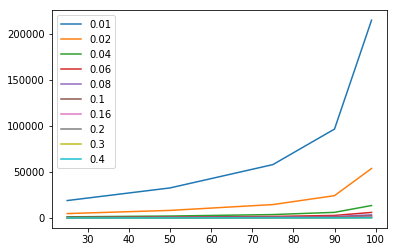

In [135]:
df.ix[:5].plot();

In [14]:
df.T

,25,50,75,90,99,mean,asn
0.01,18839,32547,57838,96411,214491,46126,46150
0.02,4725,8157,14486,24149,53640,11556,11562
0.04,1188,2051,3637,6053,13455,2900,2902
0.06,531,914,1619,2700,5980,1294,1295
0.08,301,518,916,1520,3366,730,731
0.10,193,332,587,974,2157,469,469
0.16,77,131,231,381,840,184,185
0.20,49,84,149,244,538,119,119
0.30,23,38,66,108,236,53,53
0.40,12,22,38,60,131,30,30


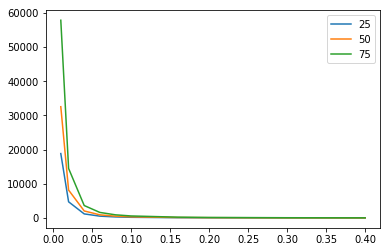

In [134]:
df.ix[:3].T.plot();

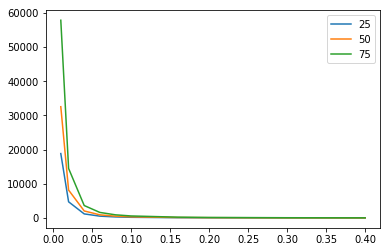

In [133]:
df.ix[:3].T.plot();

In [128]:
%matplotlib inline

In [15]:
# curve_fit(....)